In [1]:
from google.colab import drive  # Import the drive module from google.colab
drive.mount('/content/drive')  # Mount Google Drive

Mounted at /content/drive


In [2]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/MAJOR PROJECT/data/raw/creditcard.csv')
df=data.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

In [5]:
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [6]:
print(X)
print(y)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V20       V21  \
0       0.462388  0.239599  0.098698  0.363787  ...  0.25141

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Applying smote to the entire dataset for global balancing then we will standardise the data so that in future if we want to compare the performance of adaboost with other learning models. Standardistion does not have much effect when applying adaboost bit it affects other learning algorithms.

In [8]:

# Apply SMOTE to the entire dataset (Global balancing)
smote = SMOTE(random_state=42,sampling_strategy=0.5)   #here sampling_strategy=0.3% is very less
X_resampled, y_resampled = smote.fit_resample(X, y)

In [9]:
# Monitor the ratio of synthetic to original data
original_data_size = len(y)
synthetic_data_size = len(y_resampled) - original_data_size

print(f"Original Data Size: {original_data_size}")
print(f"Synthetic Data Size: {synthetic_data_size}")
print(f"Ratio of Synthetic Data: {synthetic_data_size / original_data_size:.2f}")

Original Data Size: 284807
Synthetic Data Size: 141665
Ratio of Synthetic Data: 0.50


In [10]:
#Split the balanced dataset into N nodes (subsets)
num_nodes = 3
X_split, y_split = np.array_split(X_resampled, num_nodes), np.array_split(y_resampled, num_nodes)

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [11]:
#Apply SMOTE locally at each node to further balance the data (Local balancing)
X_local_balanced, y_local_balanced = [], []
for X_node, y_node in zip(X_split, y_split):
    X_res, y_res = smote.fit_resample(X_node, y_node)

    # Monitor synthetic data for each node
    synthetic_data_size = len(y_res) - len(y_node)
    print(f"Node Data: Original size {len(y_node)}, Synthetic size {synthetic_data_size}")
    print(f"Ratio of Synthetic Data: {synthetic_data_size / len(y_node):.2f}")

    X_local_balanced.append(X_res)
    y_local_balanced.append(y_res)

Node Data: Original size 142158, Synthetic size 70675
Ratio of Synthetic Data: 0.50
Node Data: Original size 142157, Synthetic size 70744
Ratio of Synthetic Data: 0.50
Node Data: Original size 142157, Synthetic size 70340
Ratio of Synthetic Data: 0.49


In [ ]:
print(X_local_balanced)
print(y_local_balanced)

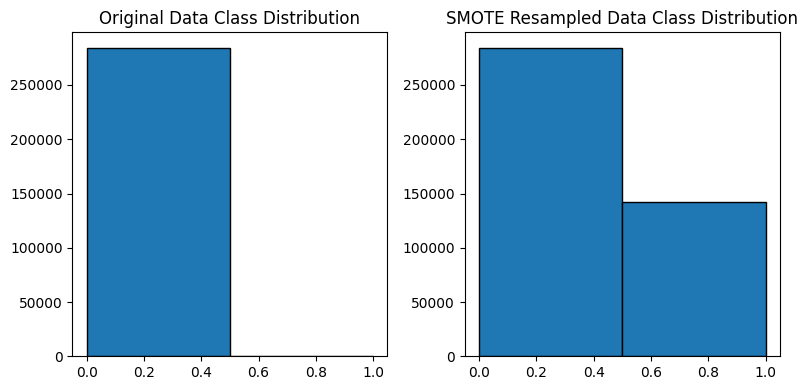

In [13]:
import matplotlib.pyplot as plt

# Plot original data class distribution
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y, bins=2, edgecolor='black')
plt.title("Original Data Class Distribution")

# Plot resampled data class distribution
plt.subplot(1, 2, 2)
plt.hist(y_resampled, bins=2, edgecolor='black')
plt.title("SMOTE Resampled Data Class Distribution")

plt.tight_layout()
plt.show()


OPTIONAL STEP!!!

In [14]:
# #Standardize the features at each node after applying SMOTE
scaler = StandardScaler()

In [15]:
X_local_scaled = []
for X_node in X_local_balanced:
    X_scaled = scaler.fit_transform(X_node)  # Fit and transform for each node independently
    X_local_scaled.append(X_scaled)

In [16]:
#Train AdaBoost on each node's data
adaboost_models = []
for X_train, y_train in zip(X_local_scaled, y_local_balanced):
    #Split data into training and test sets (80-20 split)
    X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    #Initialize and train AdaBoost model
    ada_boost_model = AdaBoostClassifier(n_estimators=50, random_state=42)
    ada_boost_model.fit(X_train_data, y_train_data)

    #Store the model
    adaboost_models.append((ada_boost_model, X_test_data, y_test_data))


In [18]:
import joblib
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('/content/drive/MyDrive/models', exist_ok=True)

for i, (model, _, _) in enumerate(adaboost_models):
    joblib.dump(model, f"/content/drive/MyDrive/models/node_{i+1}_adaboost_model.pkl")
    print(f"Node {i+1} model saved as node_{i+1}_adaboost_model.pkl in Google Drive")

Node 1 model saved as node_1_adaboost_model.pkl in Google Drive
Node 2 model saved as node_2_adaboost_model.pkl in Google Drive
Node 3 model saved as node_3_adaboost_model.pkl in Google Drive


In [19]:
# Load a saved model from Google Drive
loaded_model = joblib.load("/content/drive/MyDrive/models/node_1_adaboost_model.pkl")
print(loaded_model)


AdaBoostClassifier(random_state=42)


In [20]:
#Evaluate AdaBoost models on each node's test data
for i, (model, X_test_data, y_test_data) in enumerate(adaboost_models):
    #Make predictions
    y_pred = model.predict(X_test_data)

    #Evaluate the model
    accuracy = accuracy_score(y_test_data, y_pred)
    precision = precision_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred)

    print(f"Node {i+1} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

Node 1 Evaluation:
Accuracy: 0.9779
Precision: 0.9785
Recall: 0.9549
F1-score: 0.9666
Node 2 Evaluation:
Accuracy: 0.9828
Precision: 0.9815
Recall: 0.9670
F1-score: 0.9742
Node 3 Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Step 1: Function to Aggregate Predictions from Multiple Models
def aggregate_predictions(models, X_data):
    """Aggregate predictions from multiple AdaBoost models."""
    # Collect predictions (probabilities for class 1) from all models
    predictions = np.array([model.predict_proba(X_data)[:, 1] for model, _, _ in models])
    # Average the predictions across models
    averaged_predictions = np.mean(predictions, axis=0)
    return averaged_predictions

# Step 2: Evaluate the Aggregated Global Model
global_y_true = []  # Collect true labels from all test sets
global_y_pred = []  # Collect aggregated predictions

for model, X_test, y_test in adaboost_models:
    # Extend true labels
    global_y_true.extend(y_test)
    # Aggregate predictions for the current test set
    aggregated_preds = aggregate_predictions(adaboost_models, X_test)
    # Convert probabilities to binary predictions (0 or 1)
    global_y_pred.extend(np.round(aggregated_preds))

# Step 3: Calculate Evaluation Metrics
accuracy = accuracy_score(global_y_true, global_y_pred)
precision = precision_score(global_y_true, global_y_pred)
recall = recall_score(global_y_true, global_y_pred)
f1 = f1_score(global_y_true, global_y_pred)

# Print Results
print("Aggregated Global Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 4: Save the Global Model Wrapper
# Assuming the individual node models have been saved
# Updated path for individual node models
model_paths = [f"/content/drive/MyDrive/models/node_{i+1}_adaboost_model.pkl" for i in range(len(adaboost_models))]

class FederatedGlobalModel:
    def __init__(self, model_paths):
        """Initialize with paths to node models."""
        import joblib
        self.models = [joblib.load(path) for path in model_paths]

    def predict(self, X_data, threshold=0.5):
        """Aggregate predictions and return final classification."""
        import numpy as np
        predictions = np.array([model.predict_proba(X_data)[:, 1] for model in self.models])
        aggregated_probs = np.mean(predictions, axis=0)
        return (aggregated_probs >= threshold).astype(int), aggregated_probs

    def save(self, file_path):
        """Save the global model wrapper."""
        import joblib
        joblib.dump(self, file_path)
        print(f"Global model saved at {file_path}")

    @staticmethod
    def load(file_path):
        """Load a saved global model wrapper."""
        import joblib
        return joblib.load(file_path)

# Save the global model wrapper
global_model = FederatedGlobalModel(model_paths)
global_model.save("/content/drive/MyDrive/models/federated_global_model.pkl")
print("Global model wrapper saved at /content/drive/MyDrive/models/federated_global_model.pkl")


Aggregated Global Model Evaluation:
Accuracy: 0.6683
Precision: 0.5787
Recall: 0.9380
F1-Score: 0.7158
Global model saved at /content/drive/MyDrive/models/federated_global_model.pkl
Global model wrapper saved at /content/drive/MyDrive/models/federated_global_model.pkl


In [29]:
# Load the global model
global_model = FederatedGlobalModel.load("/content/drive/MyDrive/models/federated_global_model.pkl")

for model,x_test,y_test in adaboost_models:
    prediction, probability = global_model.predict(x_test)
    print(f"Prediction: {prediction}, Probability: {probability}")


Prediction: [1 1 0 ... 1 0 1], Probability: [0.74191323 0.74641167 0.27359402 ... 0.52092594 0.24098799 0.52411748]
Prediction: [1 0 1 ... 1 1 1], Probability: [0.7266266  0.499792   0.5024693  ... 0.51901787 0.59787495 0.55384367]
Prediction: [1 1 0 ... 1 1 1], Probability: [0.71362026 0.74975153 0.20527999 ... 0.52515201 0.71649398 0.61049306]


Cross-validation to assess how well the model generalizes across different data splits. Cross-validation helps identify if the model is overfitting to a particular subset of data:


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

# Cross-validation
scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validated accuracy: 0.9256 ± 0.0627
